In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%matplotlib inline
 
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np
from glob import glob 
from PIL import Image
import tensorflow as tf 
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
import datetime
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
all_xray = pd.read_csv('../input/data/Data_Entry_2017.csv')
bbox_list = pd.read_csv('/kaggle/input/data/BBox_List_2017.csv')


all_xray.sample(5)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
44765,00011507_003.png,No Finding,3,11507,46,F,PA,2992,2991,0.143,0.143,NaN
52480,00013249_004.png,Consolidation|Effusion,4,13249,14,M,AP,2500,2048,0.168,0.168,NaN
68403,00016892_001.png,No Finding,1,16892,54,M,PA,2048,2500,0.168,0.168,NaN
86855,00021424_003.png,No Finding,3,21424,56,M,AP,3056,2544,0.139,0.139,NaN
90304,00022454_008.png,No Finding,8,22454,54,F,PA,2936,2818,0.143,0.143,NaN


# Data Exploration

In [2]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data',  'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray.shape[0])
all_xray['path'] = all_xray['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 112120


In [3]:
all_xray["Finding Labels"].nunique()

836

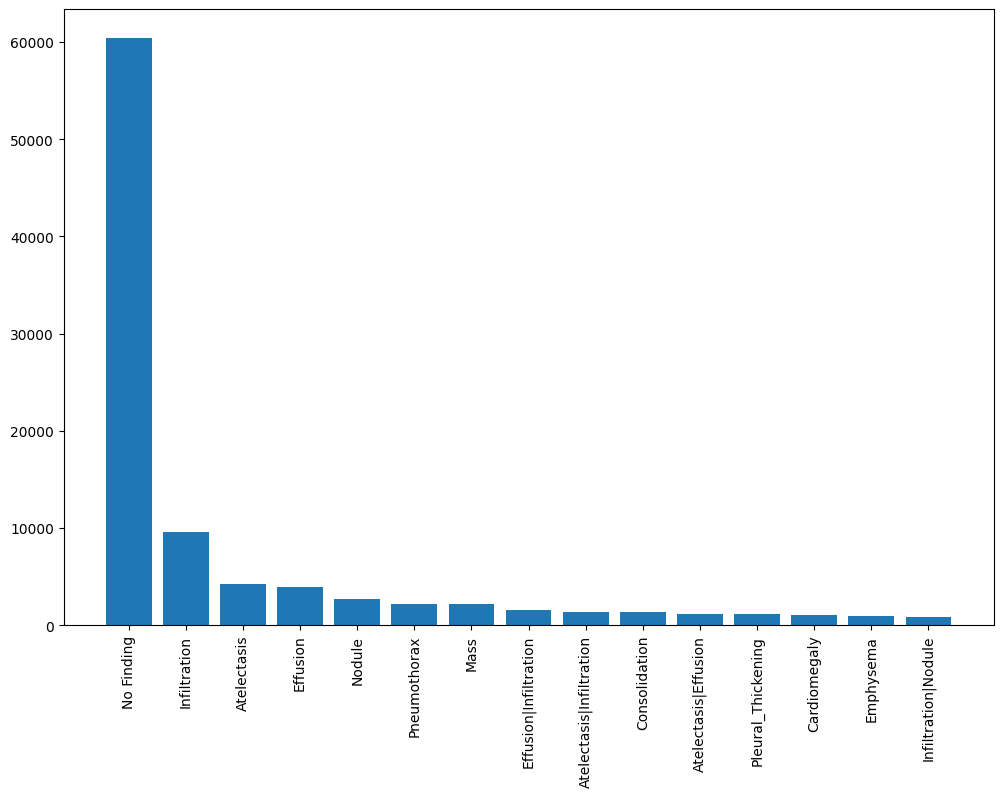

In [4]:
label_counts = all_xray['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1, 1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [5]:
bbox_labels = list(bbox_list["Finding Label"].unique())
bbox_labels

['Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltrate',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax']

In [6]:
bbox_list.sample(5)

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
539,00026538_034.png,Infiltrate,501.705820,488.702646,186.378836,222.137566,NaN,NaN,NaN
235,00022215_011.png,Cardiomegaly,394.429630,478.950265,490.869841,356.503704,NaN,NaN,NaN
522,00021710_003.png,Infiltrate,598.146032,633.904762,206.967196,182.044444,NaN,NaN,NaN
260,00008339_010.png,Cardiomegaly,348.918519,346.751323,525.544974,386.844444,NaN,NaN,NaN
453,00027577_003.png,Effusion,94.273016,211.301587,136.533333,266.565079,NaN,NaN,NaN


In [7]:
bbox_list['Finding Label'].value_counts()


Finding Label
Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: count, dtype: int64

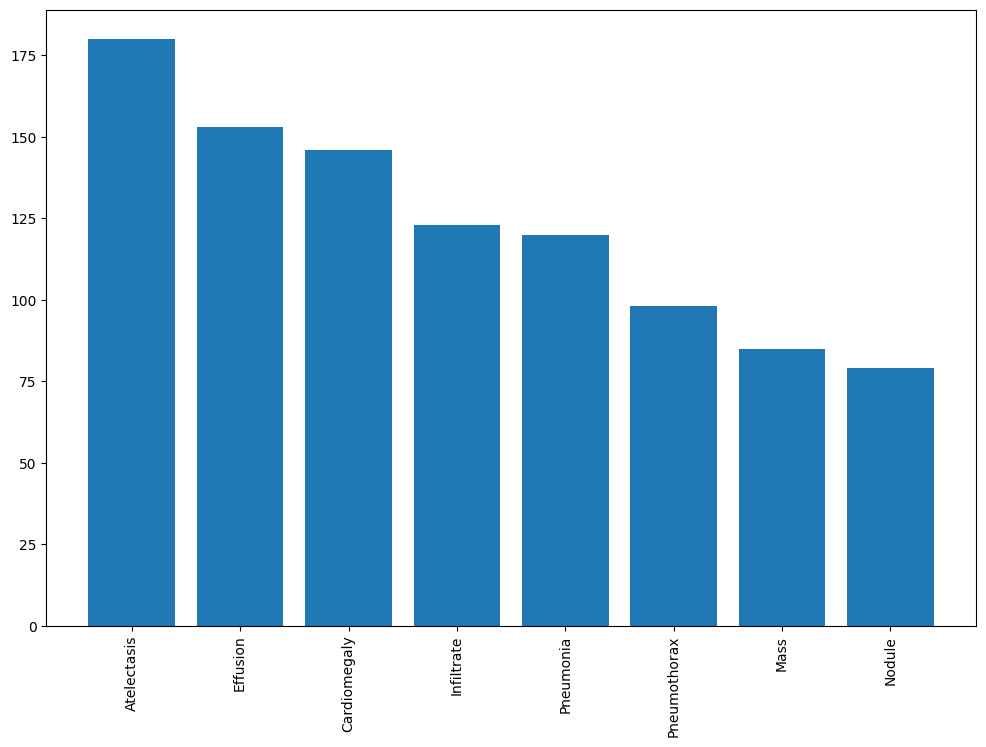

In [8]:
label_counts = bbox_list['Finding Label'].value_counts()
fig, ax1 = plt.subplots(1, 1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [9]:
A = all_xray.set_index('Image Index')
B = bbox_list.set_index('Image Index')


In [10]:
data = B.join(A, how = "inner")
data = data.reset_index(drop = False)
data = data.drop(['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 11'], axis = 1)
data.head(10)

,Image Index,Finding Label,Bbox [x,y,w,h],Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
0,00000032_037.png,Infiltrate,339.166138,119.195767,172.292063,351.085714,Cardiomegaly|Edema|Infiltration,37,32,55,F,AP,2500,2048,0.168,0.168,../input/data/images_001/images/00000032_037.png
1,00000072_000.png,Atelectasis,356.503704,567.805291,127.864550,82.353439,Atelectasis,0,72,67,F,PA,2450,2839,0.143,0.143,../input/data/images_001/images/00000072_000.png
2,00000147_001.png,Atelectasis,617.650794,599.229630,100.774603,179.877249,Atelectasis,1,147,66,F,PA,2742,2948,0.143,0.143,../input/data/images_001/images/00000147_001.png
3,00000149_006.png,Atelectasis,603.661017,460.239556,249.491525,90.033898,Atelectasis,6,149,71,M,AP,2500,2048,0.168,0.168,../input/data/images_001/images/00000149_006.png
4,00000150_002.png,Pneumonia,601.396825,595.978836,215.635979,180.960847,Atelectasis|Infiltration|Pneumonia,2,150,55,F,AP,3056,2544,0.139,0.139,../input/data/images_001/images/00000150_002.png
5,00000181_061.png,Atelectasis,209.898305,568.714132,213.694915,254.915254,Atelectasis|Effusion|Infiltration,61,181,52,F,AP,2500,2048,0.168,0.168,../input/data/images_001/images/00000181_061.png
6,00000193_019.png,Pneumonia,703.715556,616.997934,218.453333,249.173333,Pneumonia,19,193,55,M,AP,2500,2048,0.168,0.168,../input/data/images_001/images/00000193_019.png
7,00000211_010.png,Atelectasis,353.084746,535.087013,101.966102,168.135593,Atelectasis|Cardiomegaly|Effusion|Infiltration,10,211,58,F,PA,2992,2991,0.143,0.143,../input/data/images_001/images/00000211_010.png
8,00000211_016.png,Infiltrate,237.307937,465.947090,230.806349,328.330159,Cardiomegaly|Infiltration,16,211,59,F,AP,2500,2048,0.168,0.168,../input/data/images_001/images/00000211_016.png
9,00000211_019.png,Cardiomegaly,340.067797,422.779661,501.152542,406.779661,Atelectasis|Cardiomegaly|Infiltration|Pneumoth...,19,211,59,F,AP,2500,2048,0.168,0.168,../input/data/images_001/images/00000211_019.png


In [11]:
data.describe()

,Bbox [x,y,w,h],Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,398.806111,405.425364,256.334708,252.302547,13.746951,16424.805894,48.546748,2693.203252,2511.930894,0.153469,0.153469
std,222.700868,166.309995,167.629620,159.443635,20.151208,8235.918529,19.780326,354.184193,389.055550,0.016928,0.016928
min,5.417989,12.837934,27.306667,21.617778,0.000000,32.000000,2.000000,1456.000000,1555.000000,0.115000,0.115000
25%,203.093333,293.869045,136.533333,115.674074,2.000000,11098.750000,36.000000,2500.000000,2048.000000,0.139000,0.139000
50%,340.249735,412.850794,214.340942,216.949153,6.000000,16596.500000,51.000000,2714.000000,2544.000000,0.143000,0.143000
75%,607.959365,521.641995,311.832381,367.902430,17.000000,22215.000000,60.000000,2992.000000,2991.000000,0.168000,0.168000
max,905.887831,876.980783,901.120000,873.379894,168.000000,30674.000000,412.000000,3056.000000,3056.000000,0.194314,0.194314


In [12]:
data.dtypes

Image Index                     object
Finding Label                   object
Bbox [x                        float64
y                              float64
w                              float64
h]                             float64
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
path                            object
dtype: object

In [13]:
data.loc[:, 'Bbox [x':'h]']

,Bbox [x,y,w,h]
0,339.166138,119.195767,172.292063,351.085714
1,356.503704,567.805291,127.864550,82.353439
2,617.650794,599.229630,100.774603,179.877249
3,603.661017,460.239556,249.491525,90.033898
4,601.396825,595.978836,215.635979,180.960847
...,...,...,...,...
979,141.653333,611.309045,317.440000,96.711111
980,576.542373,490.612437,240.813559,222.372881
981,612.693333,459.984601,224.142222,133.120000
982,611.953785,440.509635,158.151111,151.324444


/tmp/ipykernel_47/730092200.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cv2.rectangle(img, (int(data.iloc[i, 2:6][0]), int(data.iloc[i, 2:6][1])), (int(data.iloc[i, 2:6][0] + data.iloc[i, 2:6][2]), int(data.iloc[i, 2:6][1] + data.iloc[i, 2:6][3])), (255, 0, 0), 10)


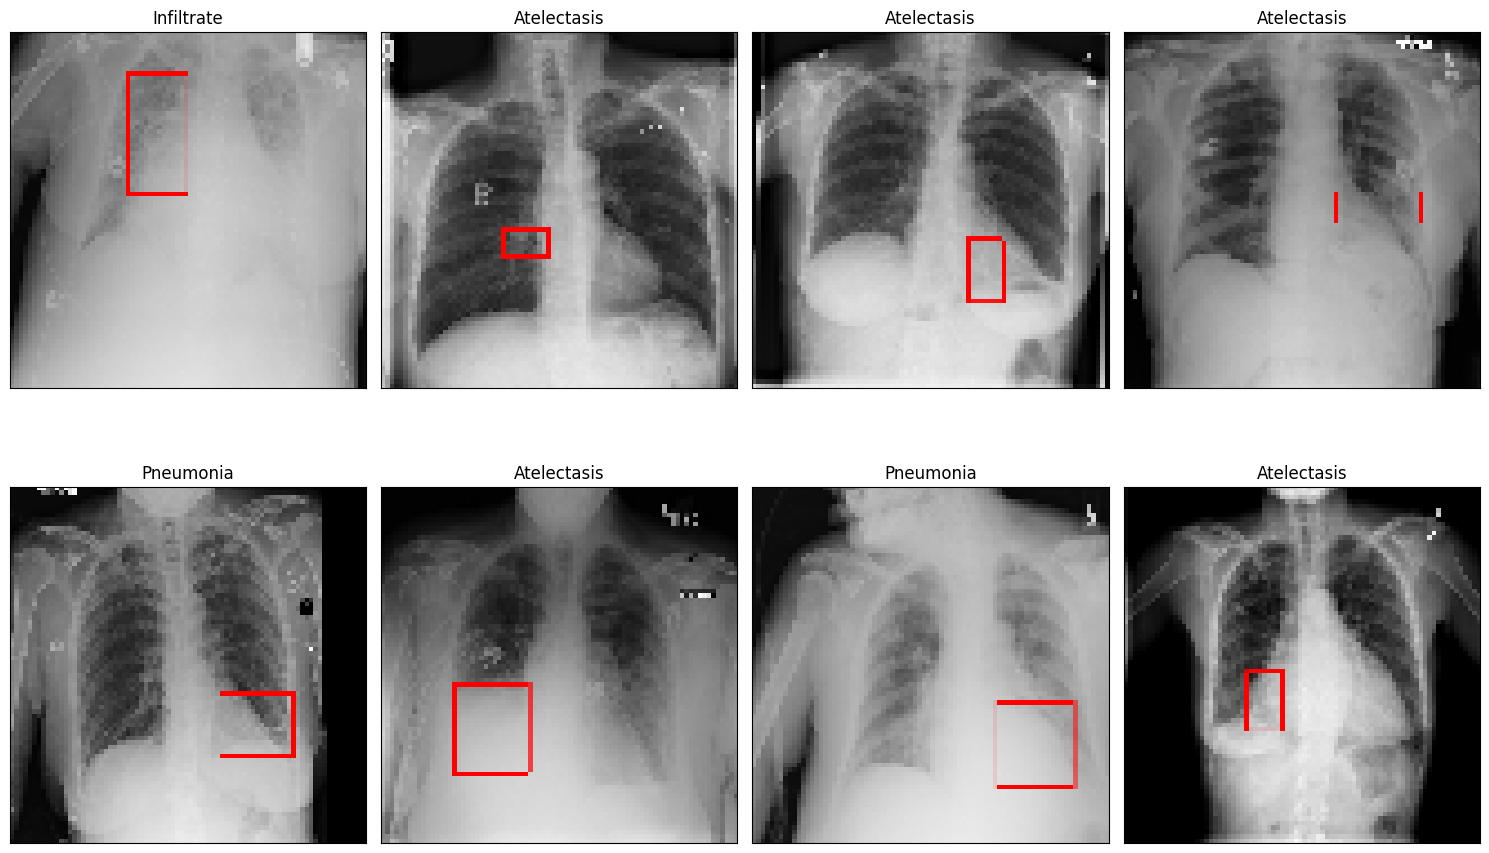

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(data.loc[i, 'path'])
    cv2.rectangle(img, (int(data.iloc[i, 2:6][0]), int(data.iloc[i, 2:6][1])), (int(data.iloc[i, 2:6][0] + data.iloc[i, 2:6][2]), int(data.iloc[i, 2:6][1] + data.iloc[i, 2:6][3])), (255, 0, 0), 10)
    img = cv2.resize(img, (80, 80))
    ax.imshow(img)
    ax.set_title(data.loc[i, 'Finding Label'])
fig.tight_layout()    

plt.show()

# Data Preprocessing

**Because we'll split the data we must identify patient overlap ( check to see if a patient's ID appears in both the training set and the test set )**

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

train_data, val_data = train_test_split(data, test_size=0.2 , random_state=42)

In [16]:
print(f" Train data shape : {train_data.shape} , Test Data shape : {val_data.shape} ")


 Train data shape : (787, 17) , Test Data shape : (197, 17) 


Extract and compare the PatientId columns from the train and validation sets :

1. **Extract patient IDs from the train and validation sets**
2. **Convert these arrays of numbers into set() datatypes for easy comparison**
3. **Identify patient overlap in the intersection of the two sets**

In [17]:
# Extract patient id's for the training set
ids_train = train_data['Patient ID'].values
# Extract patient id's for the validation set
ids_valid = val_data['Patient ID'].values

In [18]:
# Create a "set" datastructure of the training set id's to identify unique id's
ids_train_set = set(ids_train)
print(f'There are {len(ids_train_set)} unique Patient IDs in the training set')
# Create a "set" datastructure of the validation set id's to identify unique id's
ids_valid_set = set(ids_valid)
print(f'There are {len(ids_valid_set)} unique Patient IDs in the validation set')

There are 611 unique Patient IDs in the training set
There are 185 unique Patient IDs in the validation set


In [19]:
# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train_set.intersection(ids_valid_set))
n_overlap = len(patient_overlap)
print(f'There are {n_overlap} Patient IDs in both the training and validation sets')
print('')
print(f'These patients are in both the training and validation datasets:')
print(f'{patient_overlap}')

There are 70 Patient IDs in both the training and validation sets

These patients are in both the training and validation datasets:
[2176, 20482, 11269, 18055, 23176, 8841, 11402, 10120, 9608, 12045, 22416, 20113, 11925, 27927, 29464, 20124, 13471, 14626, 16291, 25252, 10277, 20393, 1836, 14253, 17582, 20274, 11827, 17972, 19124, 16568, 25529, 11322, 25787, 20408, 12094, 10815, 18496, 830, 16705, 18366, 13508, 16837, 18762, 5066, 12364, 28876, 13391, 11857, 21201, 26196, 15831, 12376, 12505, 16987, 732, 15069, 29532, 17243, 13922, 8291, 5869, 15090, 30323, 14706, 12021, 4342, 29431, 22899, 18427, 13310]


In [20]:
train_overlap_idxs = []
valid_overlap_idxs = []
for idx in range(n_overlap):
    train_overlap_idxs.extend(train_data.index[train_data['Patient ID'] == patient_overlap[idx]].tolist())
    valid_overlap_idxs.extend(val_data.index[val_data['Patient ID'] == patient_overlap[idx]].tolist())
    
print(f'These are the indices of overlapping patients in the training set: ')
print(f'{train_overlap_idxs}')
print(f'These are the indices of overlapping patients in the validation set: ')
print(f'{valid_overlap_idxs}')

These are the indices of overlapping patients in the training set: 
[58, 671, 256, 255, 551, 550, 779, 182, 183, 264, 214, 200, 289, 288, 745, 744, 747, 642, 284, 283, 282, 879, 931, 930, 929, 645, 358, 422, 421, 478, 476, 787, 788, 790, 791, 220, 219, 659, 661, 51, 50, 409, 536, 653, 651, 274, 546, 602, 601, 603, 489, 799, 258, 809, 810, 665, 293, 295, 236, 583, 28, 495, 568, 569, 571, 360, 501, 590, 118, 117, 119, 307, 914, 913, 354, 279, 690, 820, 466, 309, 311, 315, 507, 22, 441, 938, 523, 380, 169, 135, 444, 970, 426, 285, 287, 94, 93, 95, 927, 760, 581, 578, 579, 350]
These are the indices of overlapping patients in the validation set: 
[59, 670, 669, 668, 254, 552, 778, 184, 265, 213, 199, 290, 746, 643, 281, 878, 928, 644, 357, 420, 477, 479, 789, 221, 218, 660, 49, 408, 535, 652, 275, 547, 604, 490, 798, 259, 807, 808, 664, 294, 292, 237, 582, 29, 494, 570, 359, 500, 589, 120, 306, 915, 355, 280, 689, 819, 467, 312, 310, 314, 506, 23, 442, 937, 522, 381, 168, 136, 445, 969, 42

In [21]:
# Drop the overlapping patients from the validation set and add them to the training set

# Get the overlapping rows from the validation set
overlapping_rows = val_data.loc[valid_overlap_idxs]

val_data.drop(valid_overlap_idxs, inplace=True)


# Add the overlapping rows to the training set
train_data = pd.concat([train_data, overlapping_rows])

# Reset the indices of the updated training set
train_data.reset_index(drop=True, inplace=True)

Check that everything worked as planned by rerunning the patient ID comparison between train and validation sets.

In [22]:
# Extract patient id's for the validation set
ids_valid = val_data['Patient ID'].values
# Create a "set" datastructure of the validation set id's to identify unique id's
ids_valid_set = set(ids_valid)
print(f'There are {len(ids_valid_set)} unique Patient IDs in the validation set')

# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train_set.intersection(ids_valid_set))
n_overlap = len(patient_overlap)
print(f'There are {n_overlap} Patient IDs in both the training and validation sets')

There are 115 unique Patient IDs in the validation set
There are 0 Patient IDs in both the training and validation sets


**Because we're going to resize the images to 320 x 320, we also need to apply the same logic to the positions defining the regions** 

In [23]:


IMAGE_SIZE = 320
train_data['x0'] = train_data['Bbox [x'] *  IMAGE_SIZE /1024
train_data['y0'] = train_data['y'] *  IMAGE_SIZE / 1024
train_data['w0'] = train_data['w'] *  IMAGE_SIZE /1024 
train_data['h0'] = train_data['h]'] *  IMAGE_SIZE /1024

val_data['x0'] = val_data['Bbox [x'] *  IMAGE_SIZE /1024
val_data['y0'] = val_data['y'] *  IMAGE_SIZE / 1024
val_data['w0'] = val_data['w'] *  IMAGE_SIZE /1024 
val_data['h0'] = val_data['h]'] *  IMAGE_SIZE /1024

In [24]:
train_data[['path','x0','y0','h0','w0']]

,path,x0,y0,h0,w0
0,../input/data/images_012/images/00030162_026.png,168.711111,84.011854,23.111111,29.511111
1,../input/data/images_010/images/00022961_008.png,176.533333,157.967410,45.155556,66.844444
2,../input/data/images_006/images/00012975_003.png,64.677249,74.158730,63.322751,64.677249
3,../input/data/images_012/images/00028285_014.png,206.400000,142.678521,104.177778,65.777778
4,../input/data/images_008/images/00017500_002.png,239.068783,192.000000,19.301587,33.185185
...,...,...,...,...,...
859,../input/data/images_003/images/00004342_050.png,57.904762,112.761905,132.063492,42.666667
860,../input/data/images_012/images/00029431_000.png,63.111111,122.056299,147.555556,70.044444
861,../input/data/images_010/images/00022899_014.png,27.428571,193.693122,121.566138,74.158730
862,../input/data/images_009/images/00018427_004.png,166.264550,102.603175,31.492063,33.523810


In [25]:
from tqdm import tqdm 
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (320, 320))
    return img

train_img = []
for img_path in tqdm(train_data['path'].values):
    train_img.append(read_img( img_path))

val_img = []
for img_path in tqdm(val_data['path'].values):
    val_img.append(read_img( img_path))
    
    
X_train = np.array(train_img, np.float32) / 255  
X_val = np.array(val_img, np.float32) / 255  

100%|██████████| 120/120 [00:02<00:00, 41.38it/s]


In [26]:
train_data[['x0','y0','h0','w0']]

,x0,y0,h0,w0
0,168.711111,84.011854,23.111111,29.511111
1,176.533333,157.967410,45.155556,66.844444
2,64.677249,74.158730,63.322751,64.677249
3,206.400000,142.678521,104.177778,65.777778
4,239.068783,192.000000,19.301587,33.185185
...,...,...,...,...
859,57.904762,112.761905,132.063492,42.666667
860,63.111111,122.056299,147.555556,70.044444
861,27.428571,193.693122,121.566138,74.158730
862,166.264550,102.603175,31.492063,33.523810


In [27]:
y_box_train = train_data[['x0','y0','h0','w0']]
y_class_train = train_data['Finding Label']

y_box_val = val_data[['x0','y0','h0','w0']]
y_class_val = val_data['Finding Label']

# Models Implementation

In our work we'll use mainly **Intersection over Union (IoU)** but also Accuracy , Validation and training Loss
IoU metric in object detection evaluates the degree of overlap between the ground(gt) truth and prediction(pd). The ground truth and the prediction are shape-rectangular box .
Diagrammatically, IoU is defined as follows (the area of the intersection divided by the area of union between ground-truth and predicted box.



In [28]:
from keras.utils import Sequence
from keras.backend import epsilon

def loss(gt,pred):
    intersections = 0
    unions = 0
    gt = tf.cast(gt, tf.float32)  # Convert to float32 explicitly
    pred = tf.cast(pred, tf.float32)  # Convert to float32 explicitly
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

## VGG19

In [29]:
from keras import Model

from keras.applications.mobilenet import MobileNet, preprocess_input

from keras.applications.vgg19 import VGG19
from keras import regularizers 
from keras.regularizers import l2
from keras.layers import Conv2D, Reshape, Dropout , BatchNormalization

model = VGG19(include_top=False,input_shape=(320, 320, 3), weights='/kaggle/input/vggweight/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5') 



for layer in model.layers:
    layer.trainable = False
    
from keras.layers import Conv2D , Reshape
x = model.layers[-1].output
x = Conv2D(4, kernel_size=10,name="CV")(x)
#x = BatchNormalization()(x)
x = Reshape((4,))(x) 

model = Model(inputs=model.input, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 80, 128)       0     

In [30]:
model.compile(optimizer='adam',loss='mean_squared_error', metrics=IoU)
checkpoint = ModelCheckpoint('VGG_model_1.h5', save_best_only=True, save_weights_only=False , monitor='val_loss' , mode='min', verbose=1 , period=1)
history_1 = model.fit(x= X_train , y=y_box_train, epochs= 100, validation_data=(X_val,y_box_val), steps_per_epoch=None,batch_size = 16, verbose=1,callbacks=checkpoint)

Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 4485.2783 - IoU: 0.1684
Epoch 1: val_loss improved from inf to 3092.39404, saving model to VGG_model_1.h5
54/54 [==============================] - 18s 164ms/step - loss: 4485.2783 - IoU: 0.1684 - val_loss: 3092.3940 - val_IoU: 0.1644
Epoch 2/100


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 [==============================] - ETA: 0s - loss: 3129.5364 - IoU: 0.1662
Epoch 2: val_loss improved from 3092.39404 to 3027.51025, saving model to VGG_model_1.h5
54/54 [==============================] - 7s 132ms/step - loss: 3129.5364 - IoU: 0.1662 - val_loss: 3027.5103 - val_IoU: 0.1583
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 2982.9778 - IoU: 0.1736
Epoch 3: val_loss improved from 3027.51025 to 2999.45532, saving model to VGG_model_1.h5
54/54 [==============================] - 7s 131ms/step - loss: 2982.9778 - IoU: 0.1736 - val_loss: 2999.4553 - val_IoU: 0.1766
Epoch 4/100
54/54 [==============================] - ETA: 0s - loss: 2881.6228 - IoU: 0.1851
Epoch 4: val_loss improved from 2999.45532 to 2975.23071, saving model to VGG_model_1.h5
54/54 [==============================] - 7s 131ms/step - loss: 2881.6228 - IoU: 0.1851 - val_loss: 2975.2307 - val_IoU: 0.1781
Epoch 5/100
54/54 [==============================] - ETA: 0s - loss: 2792.1970 - IoU:

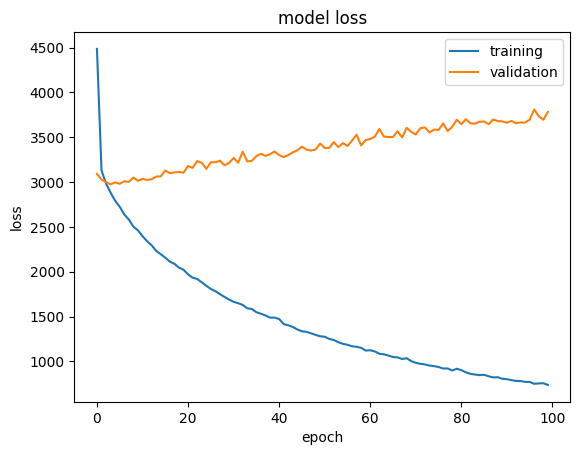

In [31]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')


plt.show()

In [32]:
"""
import numpy as np

iou_values = []
total_batches = len(validation_generator)

for i in range(total_batches):
    batch_images, batch_labels = validation_generator[i]
    predictions = model.predict(batch_images)
    
    iou = IoU(batch_labels, predictions)
    iou_values.append(iou.numpy())  # Collect IoU values for each batch

mean_iou = np.mean(iou_values)  # Calculate the mean IoU over all batches
print("Mean IoU:", mean_iou)
print("Max IoU:", np.max(iou_values))"""


'\nimport numpy as np\n\niou_values = []\ntotal_batches = len(validation_generator)\n\nfor i in range(total_batches):\n    batch_images, batch_labels = validation_generator[i]\n    predictions = model.predict(batch_images)\n    \n    iou = IoU(batch_labels, predictions)\n    iou_values.append(iou.numpy())  # Collect IoU values for each batch\n\nmean_iou = np.mean(iou_values)  # Calculate the mean IoU over all batches\nprint("Mean IoU:", mean_iou)\nprint("Max IoU:", np.max(iou_values))'

# Mobile Net (without classification head)

In [33]:
from keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import Conv2D, Reshape, Dropout , BatchNormalization, Flatten, Dense, GlobalAveragePooling2D

In [34]:
base_model = MobileNetV2(weights='/kaggle/input/mobilenet-v2-weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5', include_top=False, input_shape=(320, 320, 3))

chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

#classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
#classification_output = Dense(units=1, activation='sigmoid')(classification_output)

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

mobile_net = Model(inputs=[chopped_mobilenet.input], outputs=localization_output)

#mobile_net.summary()

In [35]:
mobile_net.compile(optimizer='adam', metrics=['accuracy', IoU],loss='mse')
checkpoint = ModelCheckpoint('mobile_net_1.h5', save_best_only=True, save_weights_only=False , monitor='val_loss' , mode='min', verbose=1 , period=1)
history = mobile_net.fit(X_train, y_box_train, validation_data=(X_val, y_box_val),epochs=100,verbose=True, callbacks = checkpoint)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 4237.3257 - accuracy: 0.3866 - IoU: 0.1680
Epoch 1: val_loss improved from inf to 5341.03223, saving model to mobile_net_1.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 23s 267ms/step - loss: 4237.3257 - accuracy: 0.3866 - IoU: 0.1680 - val_loss: 5341.0322 - val_accuracy: 0.3750 - val_IoU: 0.0491
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 1911.8906 - accuracy: 0.6435 - IoU: 0.2992
Epoch 2: val_loss improved from 5341.03223 to 4713.93750, saving model to mobile_net_1.h5
27/27 [==============================] - 6s 221ms/step - loss: 1911.8906 - accuracy: 0.6435 - IoU: 0.2992 - val_loss: 4713.9375 - val_accuracy: 0.4167 - val_IoU: 0.0622
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 1147.7152 - accuracy: 0.7292 - IoU: 0.3819
Epoch 3: val_loss did not improve from 4713.93750
27/27 [==============================] - 6s 215ms/step - loss: 1147.7152 - accuracy: 0.7292 - IoU: 0.3819 - val_loss: 5152.9946 - val_accuracy: 0.3750 - val_IoU: 0.0826
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 913.0807 - accuracy: 0.7755 - IoU: 0.4648
Epoch 4: val_loss

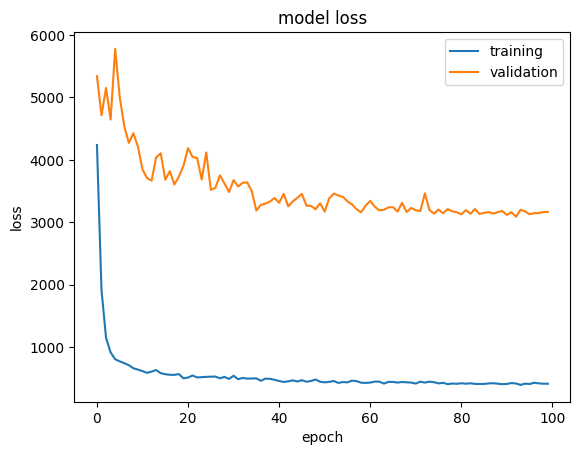

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')


plt.show()

# ResNet50 (without classification head)

In [37]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [38]:
base_model1 = ResNet50(weights='/kaggle/input/resnet-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(320, 320, 3))

chopped_resnet1 = Model(inputs=[base_model1.input], outputs=[base_model1.layers[90].output])

#classification_output1 = GlobalAveragePooling2D()(chopped_resnet1.output)
#classification_output1 = Dense(units=len(bbox_labels), activation='softmax')(classification_output1)

localization_output1 = Flatten()(chopped_resnet1.output)
localization_output1 = Dense(units=4, activation='relu')(localization_output1)

resnet_50 = Model(inputs=[chopped_resnet1.input], outputs=localization_output1)

#resnet_50.summary()

In [39]:
resnet_50.compile(optimizer='adam', metrics=['accuracy', IoU],loss='mse')#lets run it through 10 epochs
checkpoint = ModelCheckpoint('resnet_50.h5', save_best_only=True, save_weights_only=False , monitor='val_loss' , mode='min', verbose=1 , period=1)
history2=resnet_50.fit(X_train, y_box_train, validation_data=(X_val, y_box_val),epochs=100,verbose=True, callbacks = checkpoint)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 4272.3335 - accuracy: 0.4062 - IoU: 0.1719
Epoch 1: val_loss improved from inf to 10491539.00000, saving model to resnet_50.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 28s 350ms/step - loss: 4272.3335 - accuracy: 0.4062 - IoU: 0.1719 - val_loss: 10491539.0000 - val_accuracy: 0.3833 - val_IoU: 0.0000e+00
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 3047.5981 - accuracy: 0.5035 - IoU: 0.2121
Epoch 2: val_loss improved from 10491539.00000 to 4571.91943, saving model to resnet_50.h5
27/27 [==============================] - 8s 301ms/step - loss: 3047.5981 - accuracy: 0.5035 - IoU: 0.2121 - val_loss: 4571.9194 - val_accuracy: 0.3833 - val_IoU: 0.2011
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 2367.7844 - accuracy: 0.6007 - IoU: 0.2479
Epoch 3: val_loss did not improve from 4571.91943
27/27 [==============================] - 8s 283ms/step - loss: 2367.7844 - accuracy: 0.6007 - IoU: 0.2479 - val_loss: 4675.8452 - val_accuracy: 0.3333 - val_IoU: 0.0592
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 1744.4860 - accuracy: 0.6863 - IoU: 0.3280
Epoch 4

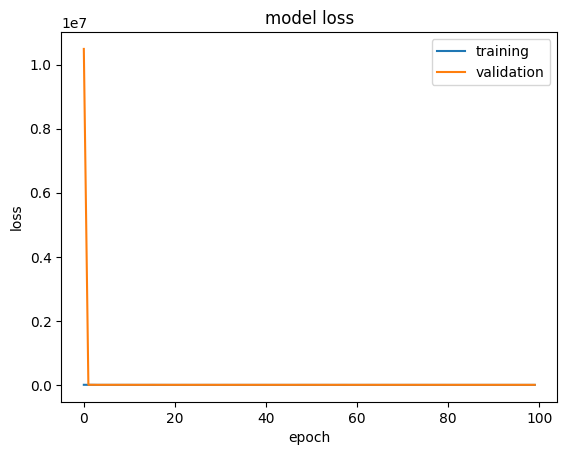

In [40]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')


plt.show()

# X-ception (without classification head)

In [41]:
from tensorflow.keras.applications.xception import Xception

In [42]:
base_model2 = Xception(weights='/kaggle/input/xception-weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(320, 320, 3))

chopped_Xception = Model(inputs=[base_model2.input], outputs=[base_model2.layers[90].output])

#classification_output2 = GlobalAveragePooling2D()(chopped_Xception.output)
#classification_output2 = Dense(units=1, activation='sigmoid')(classification_output2)

localization_output2 = Flatten()(chopped_Xception.output)
localization_output2 = Dense(units=4, activation='relu')(localization_output2)

xception = Model(inputs=[chopped_Xception.input], outputs=localization_output2)

#xception.summary()

In [43]:
xception.compile(optimizer='adam', metrics=['accuracy', IoU],loss='mse')#lets run it through 10 epochs
checkpoint = ModelCheckpoint('xception.h5', save_best_only=True, save_weights_only=False , monitor='val_loss' , mode='min', verbose=1 , period=1)
history3=xception.fit(X_train, y_box_train, validation_data=(X_val, y_box_val),epochs=100,verbose=True, callbacks = checkpoint)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 4038.1172 - accuracy: 0.3623 - IoU: 0.1548
Epoch 1: val_loss improved from inf to 3093.97119, saving model to xception.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 36s 583ms/step - loss: 4038.1172 - accuracy: 0.3623 - IoU: 0.1548 - val_loss: 3093.9712 - val_accuracy: 0.4417 - val_IoU: 0.1714
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 2279.6370 - accuracy: 0.5266 - IoU: 0.2515
Epoch 2: val_loss improved from 3093.97119 to 2996.40112, saving model to xception.h5
27/27 [==============================] - 14s 518ms/step - loss: 2279.6370 - accuracy: 0.5266 - IoU: 0.2515 - val_loss: 2996.4011 - val_accuracy: 0.4167 - val_IoU: 0.1621
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 1493.9015 - accuracy: 0.6539 - IoU: 0.3409
Epoch 3: val_loss did not improve from 2996.40112
27/27 [==============================] - 13s 500ms/step - loss: 1493.9015 - accuracy: 0.6539 - IoU: 0.3409 - val_loss: 3741.3259 - val_accuracy: 0.4583 - val_IoU: 0.1397
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 1111.5861 - accuracy: 0.7639 - IoU: 0.3969
Epoch 4: val_loss 

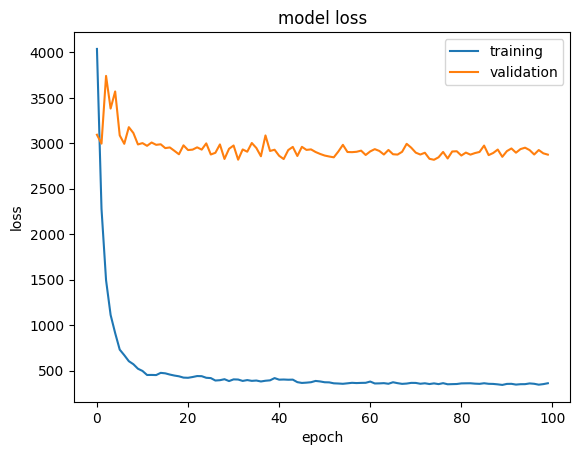

In [44]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')


plt.show()

# Model selection

After a comparaison of the Val_loss and the Val_IoU of the models, we have finally selected the **Xception model** for our final application.

# Results 

In [45]:
#Tu peux utiliser cette fonction pour le test sur le meilleur modeles

import matplotlib.patches as patches

def plot_predictions(model , sample_df, X , Y , IMAGE_SIZE ):
    for i in range(sample_df.shape[0]):
        org_x0 = Y.iloc[i][0]
        org_y0 = Y.iloc[i][1]
        org_h0 = Y.iloc[i][2]
        org_w0 = Y.iloc[i][3]

        image = cv2.resize(X[i], (IMAGE_SIZE, IMAGE_SIZE)) 
        region = model.predict(x=np.array([image]))[0]

        x0 =region[0]  
        y0 = region[1]
        h0 = region[2]
        w0 = region[3]
        # Display the image
        fig,ax = plt.subplots(1)
        ax.imshow(X[i])

        # Create a Rectangle patch
        # x1-x0 is the width of the bounding box
        # y1-y0 is the height of the bounding box
        rect_pred = patches.Rectangle((x0, y0), w0, h0, linewidth=2, edgecolor='r', facecolor='none')
        rect_org = patches.Rectangle((org_x0, org_y0), org_w0, org_h0, linewidth=2, edgecolor='b', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect_pred)
        ax.add_patch(rect_org)

        # Image coordinates - top-left of the image is (0,0)

        ax.plot(x0, y0, 'o', color='b') # top-left of the bounding box
        ax.plot(x0+w0, y0+h0, '*', color='c') # bottom-right of the bounding-box
        ax.set_title("ok")
        plt.show()
        print(Y.iloc[i])
        print(region)
        #fig.savefig('prediction'+sample_df['Image Index'][i])

/tmp/ipykernel_47/204749566.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  org_x0 = Y.iloc[i][0]
/tmp/ipykernel_47/204749566.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  org_y0 = Y.iloc[i][1]
/tmp/ipykernel_47/204749566.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  org_h0 = Y.iloc[i][2]
/tmp/ipykernel_47/204749566.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version

1/1 [==============================] - 1s 824ms/step


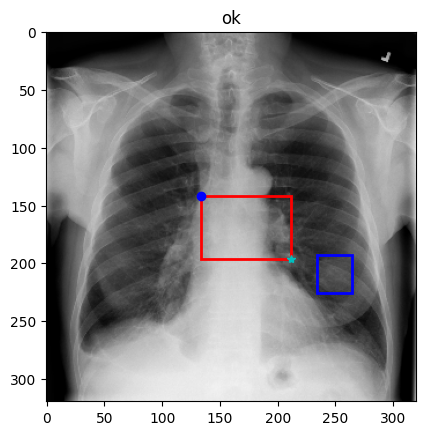

x0    234.133333
y0    192.456299
h0     33.422222
w0     30.577778
Name: 613, dtype: float64
[133.88126  141.50246   54.88897   77.320015]
1/1 [==============================] - 0s 23ms/step


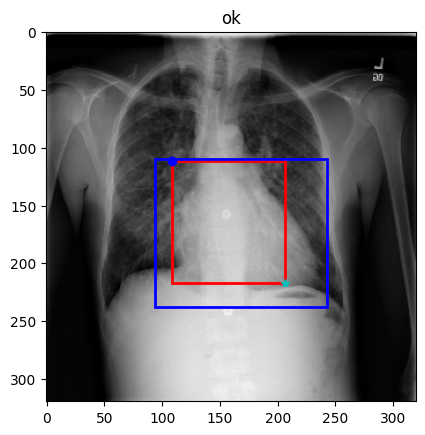

x0     93.460317
y0    109.714286
h0    128.000000
w0    149.671958
Name: 451, dtype: float64
[108.12172 111.45201 105.44332  98.06552]
1/1 [==============================] - 0s 21ms/step


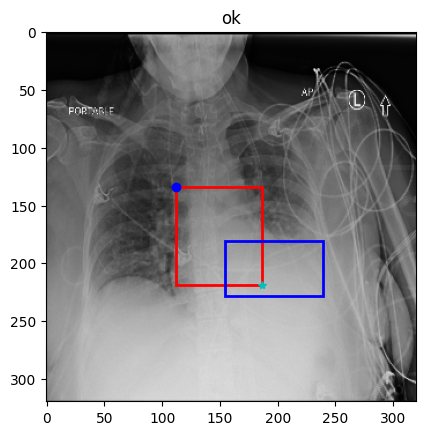

x0    154.406780
y0    180.435031
h0     48.135593
w0     84.745763
Name: 731, dtype: float64
[112.39049  134.34157   84.491905  74.03864 ]
1/1 [==============================] - 0s 21ms/step


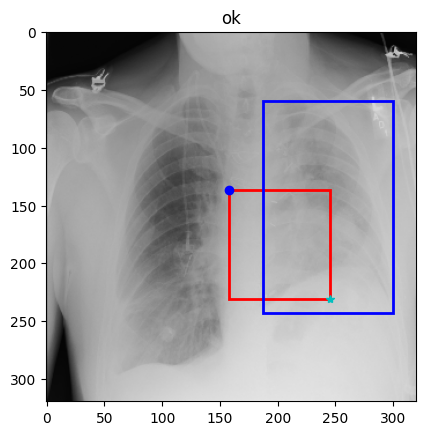

x0    187.200000
y0     59.122965
h0    183.822222
w0    112.711111
Name: 436, dtype: float64
[157.86526 136.4434   94.88693  87.25529]
1/1 [==============================] - 0s 22ms/step


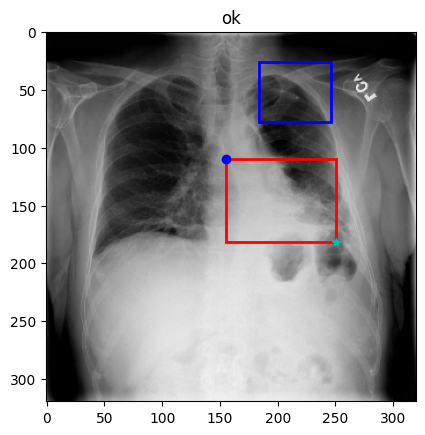

x0    183.534392
y0     26.074074
h0     51.809524
w0     62.984127
Name: 707, dtype: float64
[155.26234  109.65531   72.2253    94.862335]
1/1 [==============================] - 0s 21ms/step


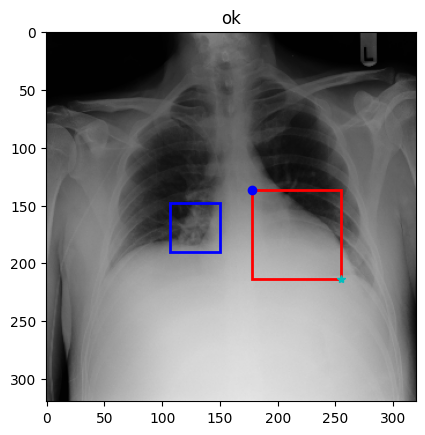

x0    106.666667
y0    147.978836
h0     42.666667
w0     43.005291
Name: 299, dtype: float64
[177.63728 136.22739  77.32631  77.58187]
1/1 [==============================] - 0s 21ms/step


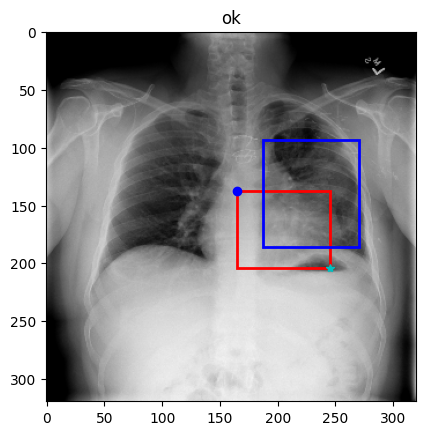

x0    187.597884
y0     93.121693
h0     93.121693
w0     82.624339
Name: 718, dtype: float64
[165.04158  137.84438   66.5108    80.645515]
1/1 [==============================] - 0s 20ms/step


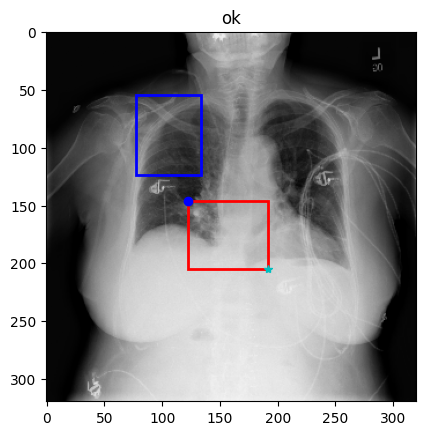

x0    77.206349
y0    54.518519
h0    69.079365
w0    56.211640
Name: 594, dtype: float64
[122.17737  146.34538   59.025352  69.12183 ]
1/1 [==============================] - 0s 22ms/step


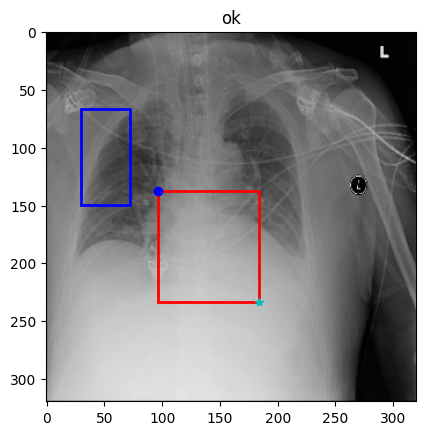

x0    29.460317
y0    66.031746
h0    83.301587
w0    42.666667
Name: 865, dtype: float64
[ 96.40618 137.41064  95.73778  87.3447 ]
1/1 [==============================] - 0s 20ms/step


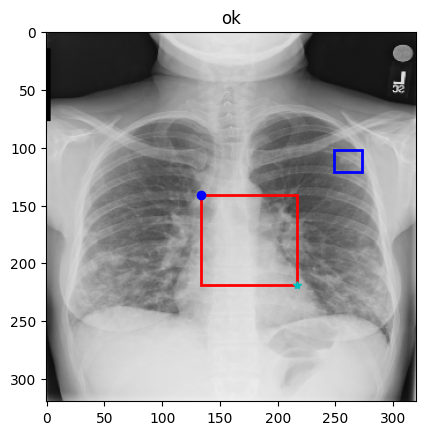

x0    248.888889
y0    102.264550
h0     18.624339
w0     24.380952
Name: 66, dtype: float64
[133.37663  140.9598    77.478874  83.70831 ]


In [47]:
sample_df = val_data.head(10)

plot_predictions(model=xception , sample_df=sample_df, X=X_val , Y=y_box_val , IMAGE_SIZE=320 )

In [ ]:
"""import os

folder_path = '/kaggle/working' 
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        os.remove(file_path)


folder_path = '/kaggle/working'
for root, dirs, files in os.walk(folder_path, topdown=False):
    for name in files:
        file_path = os.path.join(root, name)
        os.remove(file_path)
    for name in dirs:
        dir_path = os.path.join(root, name)
        os.rmdir(dir_path)
"""
